## Predict the daily number of riders using FBProphet & Grid Search

In [2]:
import pandas as pd
import os
import matplotlib.pyplot as plt
from pandas.plotting import register_matplotlib_converters
from fbprophet import Prophet
from sklearn.model_selection import ParameterGrid
from sklearn.metrics import mean_absolute_error
from sklearn import metrics
from fbprophet.plot import add_changepoints_to_plot

In [3]:
## Load data. Here are the columns.
## y: number of riders per day, and our target variable
## PRCP: precipitation
## SNOW: amount of snow
## TAVG: average temperature for the day
ts_data = pd.read_csv('data/green_taxi.csv')
#ts_data = ts_data.set_index('ds')
ts_data.head()

,ds,y,PRCP,SNOW,TAVG
0,2015-01-01,62943,0.00,0.0,33.0
1,2015-01-02,43410,0.00,0.0,38.5
2,2015-01-03,53866,0.71,0.0,37.5
3,2015-01-04,41602,0.30,0.0,48.5
4,2015-01-05,41923,0.00,0.0,35.0


In [4]:
## Let's define our time series function using FBprophet. The function will 
def run_multivariate_ts(grid, ts_data, train_end_date):
    model_num = 1 ## This will be the model_ID
    model_dict = {} ## This is a dictionary to keep track of what the model parameters corresponding to the model_ID are
    ## Split train/test based on train_end_date
    training = ts_data[ts_data['ds'] <= train_end_date]
    test = ts_data[ts_data['ds'] > train_end_date]
    ## Initialize best_model, model_num, mae, params & forecast to keep record of models so that when we run each model, 
    ## we are able to compare the performance of the current model with the best model thus far.
    best_model = None
    best_model_num = None
    best_mae = 100000000000000000000000
    best_params = ''
    best_forecast = None
    ## Grid Search with different parameters
    for p in grid:
        test_cols = ['ds']
        params = str(p['changepoint_prior_scale']) + '|' + str(p['changepoint_range'])
        holidays = pd.DataFrame(columns = ['ds', 'holiday'])
        ## Another layer in grid search to toggle holidays on/off
        if p['holidays'] == 'yes':
            model = Prophet(changepoint_prior_scale = p['changepoint_prior_scale'], changepoint_range = p['changepoint_range'],
                           holidays=holidays)
            model.add_country_holidays(country_name='US') ## built-in dataframe of US holidays
            params = params + '|' + 'holidays'
            if p['TAVG'] == 'yes':
                model.add_regressor('TAVG')
                test_cols.append('TAVG')
                params = params + '|' + 'temp'
            if p['PRCP'] == 'yes':
                model.add_regressor('PRCP')
                test_cols.append('PRCP')
                params = params + '|' + 'prcp'
            if p['SNOW'] == 'yes':
                model.add_regressor('SNOW')
                test_cols.append('SNOW')
                params = params + '|' + 'snow'
        else:
            model = Prophet(changepoint_prior_scale = p['changepoint_prior_scale'], changepoint_range = p['changepoint_range'])
            if p['TAVG'] == 'yes':
                model.add_regressor('TAVG')
                test_cols.append('TAVG')
                params = params + '|' + 'temp'
            if p['PRCP'] == 'yes':
                model.add_regressor('PRCP')
                test_cols.append('PRCP')
                params = params + '|' + 'prcp'
            if p['SNOW'] == 'yes':
                model.add_regressor('SNOW')
                test_cols.append('SNOW')
                params = params + '|' + 'snow'
        ## Now that we've set up the model parameters, we can fit the model on the training data
        model.fit(training)
        ## Lets fit the trained model on the test data to generate forecasts
        fitted = test[test_cols]
        df_forecast = model.predict(fitted)
        forecast = df_forecast['yhat'].values
        mae = metrics.mean_absolute_error(test['y'], forecast)
        ## If the mae is lower for the current model compared to the best model thus far, replace best model with the current model
        if mae < best_mae:
            best_mae = mae
            best_model = model
            best_model_num = model_num
            best_params = params
            best_forecast = df_forecast
        model_id = 'model_' + str(model_num)
        model_dict[model_num] = params
        test[model_id] = forecast
        model_num += 1
    return test, model_dict, best_model, best_model_num, best_mae, best_params, best_forecast


In [7]:
## We are now ready to run our function
params_grid = {'changepoint_prior_scale':[0.01, 0.1], ## how frequently to detect changes in trend
               'changepoint_range' : [0.8, 0.9], ## how long the model can go before detecting change in trend is prohibited
               'holidays' : ['yes'], ## whether or not to incorporate holidays in the model
               'TAVG' : ['yes', 'no'], ## wheter or not to incorporate temperature in the model
               'PRCP' : ['yes', 'no'], ## wheter or not to incorporate temperature in the model 
               'SNOW' : ['yes', 'no']} ## wheter or not to incorporate temperature in the model
grid = ParameterGrid(params_grid)
train_end_date = '2016-12-16'
results, model_dict, best_model, best_model_num, best_mae, best_params, best_forecast = run_multivariate_ts(grid, ts_data, train_end_date)
results

INFO:fbprophet:Disabling yearly seasonality. Run prophet with yearly_seasonality=True to override this.
INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.
<ipython-input-4-61eb66e9f736>:68: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  test[model_id] = forecast
INFO:fbprophet:Disabling yearly seasonality. Run prophet with yearly_seasonality=True to override this.
INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.
<ipython-input-4-61eb66e9f736>:68: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.

INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.
<ipython-input-4-61eb66e9f736>:68: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  test[model_id] = forecast
INFO:fbprophet:Disabling yearly seasonality. Run prophet with yearly_seasonality=True to override this.
INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.
<ipython-input-4-61eb66e9f736>:68: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  test[model_id] =

INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.
<ipython-input-4-61eb66e9f736>:68: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  test[model_id] = forecast
INFO:fbprophet:Disabling yearly seasonality. Run prophet with yearly_seasonality=True to override this.
INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.
<ipython-input-4-61eb66e9f736>:68: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  test[model_id] =

,ds,y,PRCP,SNOW,TAVG,model_1,model_2,model_3,model_4,model_5,...,model_23,model_24,model_25,model_26,model_27,model_28,model_29,model_30,model_31,model_32
716,2016-12-17,48264,0.73,2.8,31.5,47976.164312,47995.848972,48421.877195,48910.058444,46611.101928,...,46657.993263,48139.425219,52238.475857,52111.049203,52275.813753,53022.916086,51288.794869,51354.534051,51281.119053,52504.233900
717,2016-12-18,42249,0.04,0.0,44.5,41679.952779,41731.017479,40859.222608,41576.981690,40797.041448,...,41694.023217,43221.181787,42026.080209,41891.313845,41098.387109,41998.467689,41477.784528,41537.282716,41472.184002,42715.936325
718,2016-12-19,37711,0.00,0.0,27.0,31041.184794,31007.817125,31431.948040,31860.890895,29115.429589,...,29965.924606,31505.570253,30854.264195,30694.947545,31209.720879,31902.998531,29703.695711,29743.716519,29636.356728,30883.493671
719,2016-12-20,37990,0.00,0.0,26.5,31871.941834,31892.673795,32378.970217,32817.153650,29905.809014,...,30930.339155,32517.592305,31786.389673,31655.797899,32268.229377,32989.739614,30639.147789,30689.706850,30631.123815,31921.219856
720,2016-12-21,38920,0.00,0.0,35.0,34033.121530,34061.741024,33933.679261,34520.603308,32525.426685,...,33484.353734,35103.035502,34285.430839,34145.965654,34118.141200,34948.369678,33385.499196,33436.160303,33377.768554,34692.265807
721,2016-12-22,40663,0.00,0.0,43.0,37425.493430,37477.093127,36688.154029,37438.457829,36389.437025,...,37412.201091,39068.227521,37749.927393,37611.725459,36930.898718,37877.674183,37118.825030,37176.394810,37156.147703,38498.779556
722,2016-12-23,43206,0.00,0.0,42.5,44445.962189,44466.681546,43689.023473,44465.976561,43455.577284,...,44500.633010,46182.618995,44687.970842,44538.333775,43864.538162,44824.517632,44085.546959,44138.765054,44194.976135,45557.009544
723,2016-12-24,40745,0.47,0.0,42.5,52667.282721,52708.802513,51994.754169,52770.394221,51657.406395,...,51859.393160,53588.330297,51590.312128,51448.752159,50616.842823,51624.951540,51006.936411,51073.842326,51082.114617,52479.655993
724,2016-12-25,26502,0.00,0.0,43.0,27592.233450,30197.670875,25390.625304,25300.294745,26525.201674,...,23912.250902,25449.003722,29046.649344,30095.913419,25166.476316,26468.777878,28324.312135,28936.289002,23686.229889,25135.583120
725,2016-12-26,23392,0.02,0.0,41.5,29910.436088,29905.299877,29062.351566,29860.275063,28846.229892,...,29802.682017,31568.689665,30089.889058,29914.624732,29155.749212,30150.679443,29421.837253,29463.024795,29437.352292,30858.915764


In [8]:
## Dataframe containing all forecasts from all models
results

,ds,y,PRCP,SNOW,TAVG,model_1,model_2,model_3,model_4,model_5,...,model_23,model_24,model_25,model_26,model_27,model_28,model_29,model_30,model_31,model_32
716,2016-12-17,48264,0.73,2.8,31.5,47976.164312,47995.848972,48421.877195,48910.058444,46611.101928,...,46657.993263,48139.425219,52238.475857,52111.049203,52275.813753,53022.916086,51288.794869,51354.534051,51281.119053,52504.233900
717,2016-12-18,42249,0.04,0.0,44.5,41679.952779,41731.017479,40859.222608,41576.981690,40797.041448,...,41694.023217,43221.181787,42026.080209,41891.313845,41098.387109,41998.467689,41477.784528,41537.282716,41472.184002,42715.936325
718,2016-12-19,37711,0.00,0.0,27.0,31041.184794,31007.817125,31431.948040,31860.890895,29115.429589,...,29965.924606,31505.570253,30854.264195,30694.947545,31209.720879,31902.998531,29703.695711,29743.716519,29636.356728,30883.493671
719,2016-12-20,37990,0.00,0.0,26.5,31871.941834,31892.673795,32378.970217,32817.153650,29905.809014,...,30930.339155,32517.592305,31786.389673,31655.797899,32268.229377,32989.739614,30639.147789,30689.706850,30631.123815,31921.219856
720,2016-12-21,38920,0.00,0.0,35.0,34033.121530,34061.741024,33933.679261,34520.603308,32525.426685,...,33484.353734,35103.035502,34285.430839,34145.965654,34118.141200,34948.369678,33385.499196,33436.160303,33377.768554,34692.265807
721,2016-12-22,40663,0.00,0.0,43.0,37425.493430,37477.093127,36688.154029,37438.457829,36389.437025,...,37412.201091,39068.227521,37749.927393,37611.725459,36930.898718,37877.674183,37118.825030,37176.394810,37156.147703,38498.779556
722,2016-12-23,43206,0.00,0.0,42.5,44445.962189,44466.681546,43689.023473,44465.976561,43455.577284,...,44500.633010,46182.618995,44687.970842,44538.333775,43864.538162,44824.517632,44085.546959,44138.765054,44194.976135,45557.009544
723,2016-12-24,40745,0.47,0.0,42.5,52667.282721,52708.802513,51994.754169,52770.394221,51657.406395,...,51859.393160,53588.330297,51590.312128,51448.752159,50616.842823,51624.951540,51006.936411,51073.842326,51082.114617,52479.655993
724,2016-12-25,26502,0.00,0.0,43.0,27592.233450,30197.670875,25390.625304,25300.294745,26525.201674,...,23912.250902,25449.003722,29046.649344,30095.913419,25166.476316,26468.777878,28324.312135,28936.289002,23686.229889,25135.583120
725,2016-12-26,23392,0.02,0.0,41.5,29910.436088,29905.299877,29062.351566,29860.275063,28846.229892,...,29802.682017,31568.689665,30089.889058,29914.624732,29155.749212,30150.679443,29421.837253,29463.024795,29437.352292,30858.915764


In [9]:
## Here is the dictionary that stores which parameters belong to which model number
model_dict

{1: '0.01|0.8|holidays|temp|prcp|snow',
 2: '0.01|0.9|holidays|temp|prcp|snow',
 3: '0.1|0.8|holidays|temp|prcp|snow',
 4: '0.1|0.9|holidays|temp|prcp|snow',
 5: '0.01|0.8|holidays|prcp|snow',
 6: '0.01|0.9|holidays|prcp|snow',
 7: '0.1|0.8|holidays|prcp|snow',
 8: '0.1|0.9|holidays|prcp|snow',
 9: '0.01|0.8|holidays|temp|prcp',
 10: '0.01|0.9|holidays|temp|prcp',
 11: '0.1|0.8|holidays|temp|prcp',
 12: '0.1|0.9|holidays|temp|prcp',
 13: '0.01|0.8|holidays|prcp',
 14: '0.01|0.9|holidays|prcp',
 15: '0.1|0.8|holidays|prcp',
 16: '0.1|0.9|holidays|prcp',
 17: '0.01|0.8|holidays|temp|snow',
 18: '0.01|0.9|holidays|temp|snow',
 19: '0.1|0.8|holidays|temp|snow',
 20: '0.1|0.9|holidays|temp|snow',
 21: '0.01|0.8|holidays|snow',
 22: '0.01|0.9|holidays|snow',
 23: '0.1|0.8|holidays|snow',
 24: '0.1|0.9|holidays|snow',
 25: '0.01|0.8|holidays|temp',
 26: '0.01|0.9|holidays|temp',
 27: '0.1|0.8|holidays|temp',
 28: '0.1|0.9|holidays|temp',
 29: '0.01|0.8|holidays',
 30: '0.01|0.9|holidays',
 31

In [10]:
## Model, MAE, params for best model
best_model, best_mae, best_params

(<fbprophet.forecaster.Prophet at 0x7fbcf81313d0>,
 4068.940806767049,
 '0.1|0.8|holidays|temp|snow')

In [11]:
## Here's forecasts generated along with the components which resulted in each prediction
best_forecast

,ds,trend,yhat_lower,yhat_upper,trend_lower,trend_upper,Christmas Day,Christmas Day_lower,Christmas Day_upper,Christmas Day (Observed),...,holidays,holidays_lower,holidays_upper,weekly,weekly_lower,weekly_upper,multiplicative_terms,multiplicative_terms_lower,multiplicative_terms_upper,yhat
0,2016-12-17,36247.586501,42304.643840,52335.398214,36247.586501,36247.586501,0.000000,0.000000,0.000000,0.0,...,0.000000,0.000000,0.000000,13225.683915,13225.683915,13225.683915,0.0,0.0,0.0,47461.357112
1,2016-12-18,36186.219226,35969.806163,46116.037276,36186.219226,36186.219226,0.000000,0.000000,0.000000,0.0,...,0.000000,0.000000,0.000000,3047.668049,3047.668049,3047.668049,0.0,0.0,0.0,41112.910683
2,2016-12-19,36124.851951,26717.976171,36952.506447,36124.851951,36124.851951,0.000000,0.000000,0.000000,0.0,...,0.000000,0.000000,0.000000,-8634.207868,-8634.207868,-8634.207868,0.0,0.0,0.0,31607.038112
3,2016-12-20,36063.484676,27631.550642,37573.191264,36063.484676,36063.484676,0.000000,0.000000,0.000000,0.0,...,0.000000,0.000000,0.000000,-7617.044130,-7617.044130,-7617.044130,0.0,0.0,0.0,32626.759449
4,2016-12-21,36002.117401,29487.418375,39157.788652,36002.117401,36002.117401,0.000000,0.000000,0.000000,0.0,...,0.000000,0.000000,0.000000,-4938.364329,-4938.364329,-4938.364329,0.0,0.0,0.0,34157.349103
5,2016-12-22,35940.750126,32093.723954,42097.109713,35940.657335,35940.802458,0.000000,0.000000,0.000000,0.0,...,0.000000,0.000000,0.000000,-1024.373911,-1024.373911,-1024.373911,0.0,0.0,0.0,36987.174249
6,2016-12-23,35879.382852,39000.410360,49356.074251,35876.769131,35882.770600,0.000000,0.000000,0.000000,0.0,...,0.000000,0.000000,0.000000,5940.638275,5940.638275,5940.638275,0.0,0.0,0.0,43954.744034
7,2016-12-24,35818.015577,46327.613512,56115.288011,35811.233075,35826.220069,0.000000,0.000000,0.000000,0.0,...,0.000000,0.000000,0.000000,13225.683915,13225.683915,13225.683915,0.0,0.0,0.0,51178.422399
8,2016-12-25,35756.648302,20740.894394,30524.382808,35744.571196,35771.125915,-15482.755576,-15482.755576,-15482.755576,0.0,...,-15482.755576,-15482.755576,-15482.755576,3047.668049,3047.668049,3047.668049,0.0,0.0,0.0,25392.358808
9,2016-12-26,35695.281027,24519.761139,34296.206864,35674.293870,35715.075783,0.000000,0.000000,0.000000,0.0,...,0.000000,0.000000,0.000000,-8634.207868,-8634.207868,-8634.207868,0.0,0.0,0.0,29323.645817


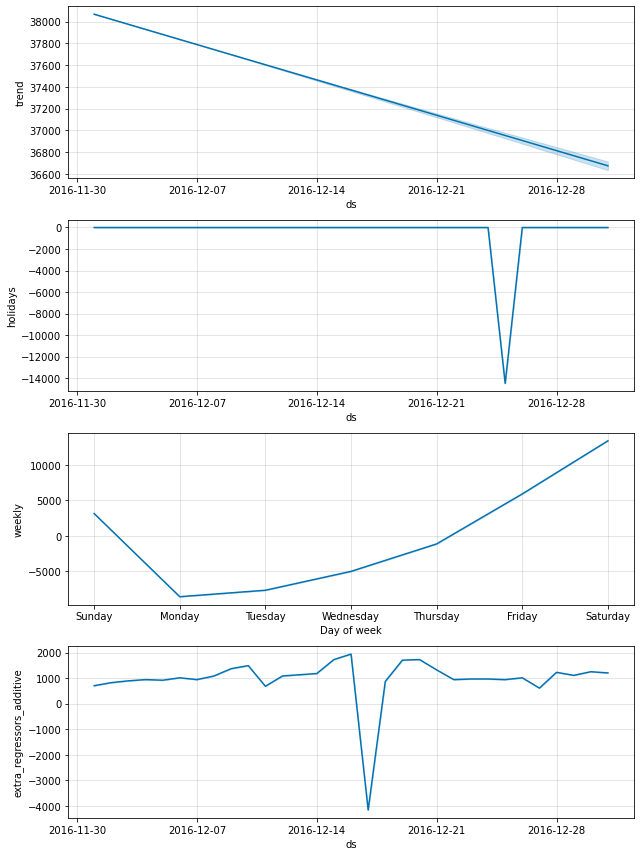

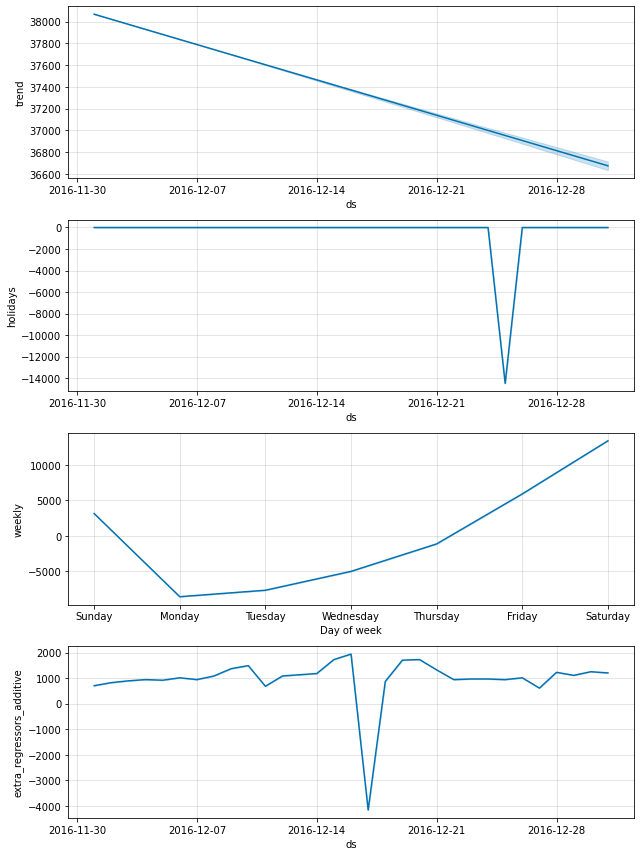

In [22]:
## Decomposition of model into trend, seasonalities
best_model.plot_components(best_forecast)

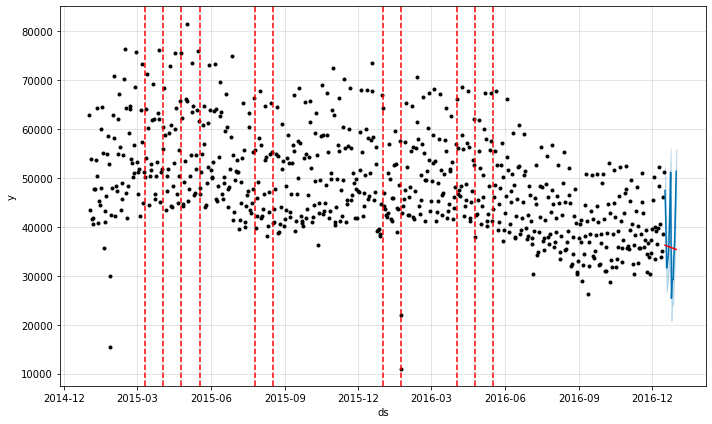

In [12]:
## Plot forecasts. The red vertical lines indicate a change in trend
fig = best_model.plot(best_forecast)
a = add_changepoints_to_plot(fig.gca(), best_model, best_forecast)

INFO:matplotlib.category:Using categorical units to plot a list of strings that are all parsable as floats or dates. If these strings should be plotted as numbers, cast to the appropriate data type before plotting.
INFO:matplotlib.category:Using categorical units to plot a list of strings that are all parsable as floats or dates. If these strings should be plotted as numbers, cast to the appropriate data type before plotting.


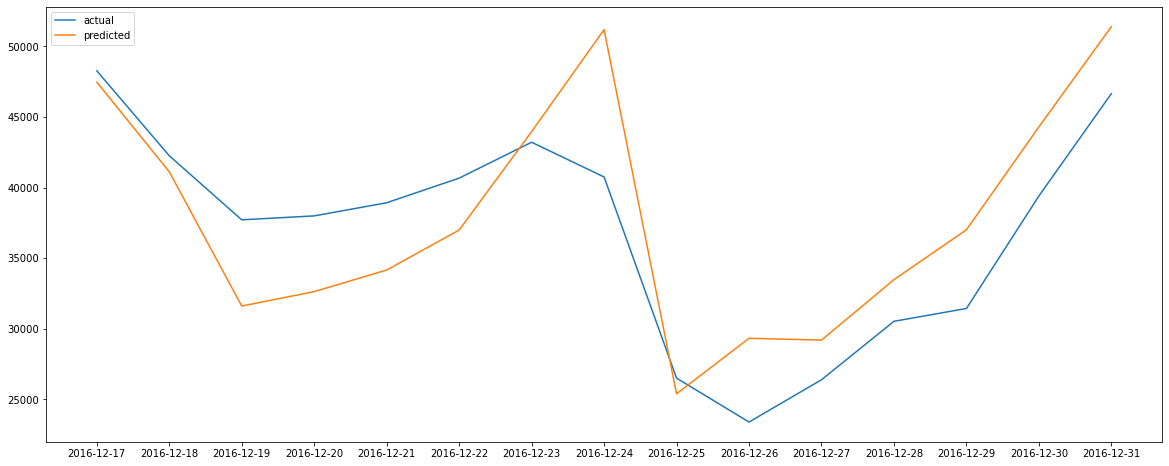

In [13]:
## Visualize predictions vs. actual
results = results.set_index('ds')        
plt.figure(figsize=(20,8))
plt.plot(results['y'], label = 'actual')
plt.plot(best_forecast['yhat'], label = 'predicted')
plt.legend()
plt.show()
## It seems like the predictions are underpredicting the peaks and overpredicting the valleys a bit
## It also seems like the forecasts generally over predict the end-of-year holiday season; 
## perhaps the "holidays" adjustment may be a bit too much?